# 6) Supervised Euclidean
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Import statements
Following packages are necessary:

In [2]:
import random
import utils
import os
import imageio
import json

import tensorflow as tf
import numpy as np
import segmentation_models as sm

from unet import UNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from sklearn.model_selection import train_test_split
from segmentation_models.losses import dice_loss
from segmentation_models.metrics import iou_score
from lastengen import LASTENSequence
from matplotlib import pyplot as plt

# Checks
The version of tensorflow as well as the GPU support are checked.

In [3]:
print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.get_visible_devices('GPU')

2.2.0-rc3


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  # Disable all GPUS
  tf.config.set_visible_devices([], 'GPU')
  visible_devices = tf.config.get_visible_devices()
  for device in visible_devices:
    assert device.device_type != 'GPU'
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

print(tf.config.get_visible_devices('GPU'))
print(tf.config.get_visible_devices('CPU'))

[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Data
Import training images

In [5]:
path = r'/home/julian/Documents/Studium/MT-Masterarbeit/Data/SIMPLE'

width = 112
height = 112

# Seeding
Seeds are set to ensure reproducible training.

In [6]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [7]:
model = UNet(filters=16, layers=4, activation='linear', classes=2, input_shape=(112, 112, 2))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 16) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Data Preparation
The generator sequence for training is built.

In [29]:
fixed = imageio.imread(path + "/fixed.png")
moving = imageio.imread(path + "/moving.png")

fixed = fixed[:,:,0]
moving = moving[:,:,0]

X = np.zeros((width, height, 2))

X[:,:,0] = moving
X[:,:,1] = fixed

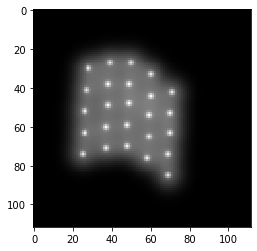

In [31]:
plt.imshow(X[:,:,0], cmap="gray")

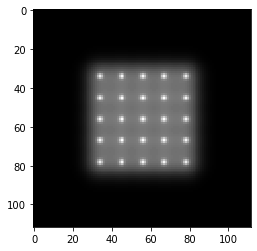

In [32]:
plt.imshow(X[:,:,1], cmap="gray")

In [53]:
moving_json_file = open(path  + '/moving.json')
fixed_json_file = open(path + '/fixed.json')

moving_data = json.load(moving_json_file)
fixed_data = json.load(fixed_json_file)

moving_json_file.close()
fixed_json_file.close()

labels = np.zeros((25,2,2))


for index in range(0,25):
    x = moving_data[str(index)][0]
    y = moving_data[str(index)][1]

    labels[index][0][0] = x
    labels[index][1][0] = y
    
for index in range(0,25):
    x = fixed_data[str(index)][0]
    y = fixed_data[str(index)][1]

    labels[index][0][1] = x
    labels[index][1][1] = y  

# Training Preparation
Prepare the settings for training the model.

In [ ]:
def custom_loss(prediction, labels):
    prediction.shape # 112x112x2 (x, y, ux-uy)
    labels.shape # 25x2x2 (coord, x-y, mov-fix)
    
    prediction[:,:,0][label[]]

In [7]:
logger = CSVLogger("experiments/segmentation.log")
checker = ModelCheckpoint("experiments/segmentation/weights.{epoch:02d}.hdf5",
                          period=50)

callbacks = [logger, checker]

model.compile(optimizer='adam',
              loss = custom_loss)

# Training
The model is fitted with a generator.

In [8]:
model.fit_generator(train_gen,
                    epochs=1000,
                    callbacks=callbacks,
                    validation_data=train_gen,
                    validation_freq=1,
                    use_multiprocessing=False,
                    workers=10,
                    max_queue_size=32)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 0.9588 - accuracy: 0.2879 - iou_score: 0.0210 - val_loss: 0.9627 - val_accuracy: 0.0062 - val_iou_score: 0.0190
Epoch 2/1000
1/1 [==============================] - 1s 534ms/step - loss: 0.9253 - accuracy: 0.5708 - iou_score: 0.0388 - val_loss: 0.9619 - val_accuracy: 0.0062 - val_iou_score: 0.0194
Epoch 3/1000
1/1 [==============================] - 1s 534ms/step - loss: 0.9068 - accuracy: 0.7113 - iou_score: 0.0489 - val_loss: 0.9619 - val_accuracy: 0.0062 - val_iou_score: 0.0194
Epoch 4/1000
1/1 [==============================] - 1s 532ms/step - loss: 0.8920 - accuracy: 0.7478 - iou_score: 0.0571 - val_loss: 0.9619 - val_accuracy: 0.0062 - val_iou_score: 0.0194
Epoch 5/1000
1/1 [==============================] - 1s 538ms/step - loss: 0.8815 - accuracy: 0.7749 - iou_score: 0.0630 - val_loss: 0.9619 - val_accuracy: 0.0062 - val_iou_score: 0.01

Epoch 87/1000
1/1 [==============================] - 1s 534ms/step - loss: 0.4343 - accuracy: 0.9605 - iou_score: 0.3944 - val_loss: 0.9650 - val_accuracy: 0.0320 - val_iou_score: 0.0178
Epoch 88/1000
1/1 [==============================] - 1s 534ms/step - loss: 0.4409 - accuracy: 0.9595 - iou_score: 0.3880 - val_loss: 0.9649 - val_accuracy: 0.0328 - val_iou_score: 0.0178
Epoch 89/1000
1/1 [==============================] - 1s 533ms/step - loss: 0.4294 - accuracy: 0.9602 - iou_score: 0.3992 - val_loss: 0.9657 - val_accuracy: 0.0386 - val_iou_score: 0.0175
Epoch 90/1000
1/1 [==============================] - 1s 538ms/step - loss: 0.4223 - accuracy: 0.9613 - iou_score: 0.4062 - val_loss: 0.9673 - val_accuracy: 0.0521 - val_iou_score: 0.0166
Epoch 91/1000
1/1 [==============================] - 1s 531ms/step - loss: 0.4052 - accuracy: 0.9623 - iou_score: 0.4233 - val_loss: 0.9729 - val_accuracy: 0.1002 - val_iou_score: 0.0137
Epoch 92/1000
1/1 [==============================] - 1s 534ms/ste

Epoch 131/1000
1/1 [==============================] - 1s 533ms/step - loss: 0.2739 - accuracy: 0.9646 - iou_score: 0.5700 - val_loss: 0.9956 - val_accuracy: 0.9586 - val_iou_score: 0.0022
Epoch 132/1000
1/1 [==============================] - 1s 534ms/step - loss: 0.2686 - accuracy: 0.9646 - iou_score: 0.5765 - val_loss: 0.9948 - val_accuracy: 0.9586 - val_iou_score: 0.0026
Epoch 133/1000
1/1 [==============================] - 1s 531ms/step - loss: 0.2686 - accuracy: 0.9646 - iou_score: 0.5766 - val_loss: 0.9933 - val_accuracy: 0.9586 - val_iou_score: 0.0034
Epoch 134/1000
1/1 [==============================] - 1s 533ms/step - loss: 0.2645 - accuracy: 0.9646 - iou_score: 0.5817 - val_loss: 0.9926 - val_accuracy: 0.9586 - val_iou_score: 0.0037
Epoch 135/1000
1/1 [==============================] - 1s 534ms/step - loss: 0.2614 - accuracy: 0.9647 - iou_score: 0.5855 - val_loss: 0.9918 - val_accuracy: 0.9586 - val_iou_score: 0.0041
Epoch 136/1000
1/1 [==============================] - 1s 535

Epoch 218/1000
1/1 [==============================] - 1s 532ms/step - loss: 0.1847 - accuracy: 0.9648 - iou_score: 0.6881 - val_loss: 0.9719 - val_accuracy: 0.9587 - val_iou_score: 0.0142
Epoch 219/1000
1/1 [==============================] - 1s 533ms/step - loss: 0.1863 - accuracy: 0.9648 - iou_score: 0.6859 - val_loss: 0.9570 - val_accuracy: 0.9588 - val_iou_score: 0.0220
Epoch 220/1000
1/1 [==============================] - 1s 534ms/step - loss: 0.1823 - accuracy: 0.9648 - iou_score: 0.6916 - val_loss: 0.9389 - val_accuracy: 0.9589 - val_iou_score: 0.0315
Epoch 221/1000
1/1 [==============================] - 1s 531ms/step - loss: 0.1839 - accuracy: 0.9648 - iou_score: 0.6893 - val_loss: 0.9388 - val_accuracy: 0.9589 - val_iou_score: 0.0316
Epoch 222/1000
1/1 [==============================] - 1s 531ms/step - loss: 0.1821 - accuracy: 0.9648 - iou_score: 0.6918 - val_loss: 0.9511 - val_accuracy: 0.9588 - val_iou_score: 0.0251
Epoch 223/1000
1/1 [==============================] - 1s 530

Epoch 305/1000
1/1 [==============================] - 1s 533ms/step - loss: 0.1626 - accuracy: 0.9648 - iou_score: 0.7203 - val_loss: 0.6120 - val_accuracy: 0.9617 - val_iou_score: 0.2407
Epoch 306/1000
1/1 [==============================] - 1s 531ms/step - loss: 0.1625 - accuracy: 0.9648 - iou_score: 0.7204 - val_loss: 0.6066 - val_accuracy: 0.9617 - val_iou_score: 0.2449
Epoch 307/1000
1/1 [==============================] - 1s 532ms/step - loss: 0.1625 - accuracy: 0.9648 - iou_score: 0.7205 - val_loss: 0.6010 - val_accuracy: 0.9618 - val_iou_score: 0.2492
Epoch 308/1000
1/1 [==============================] - 1s 533ms/step - loss: 0.1624 - accuracy: 0.9648 - iou_score: 0.7206 - val_loss: 0.5977 - val_accuracy: 0.9618 - val_iou_score: 0.2518
Epoch 309/1000
1/1 [==============================] - 1s 534ms/step - loss: 0.1623 - accuracy: 0.9648 - iou_score: 0.7207 - val_loss: 0.5957 - val_accuracy: 0.9618 - val_iou_score: 0.2533
Epoch 310/1000
1/1 [==============================] - 1s 534

Epoch 392/1000
1/1 [==============================] - 1s 532ms/step - loss: 0.1579 - accuracy: 0.9648 - iou_score: 0.7272 - val_loss: 0.3367 - val_accuracy: 0.9641 - val_iou_score: 0.4963
Epoch 393/1000
1/1 [==============================] - 1s 532ms/step - loss: 0.1579 - accuracy: 0.9648 - iou_score: 0.7272 - val_loss: 0.3354 - val_accuracy: 0.9641 - val_iou_score: 0.4977
Epoch 394/1000
1/1 [==============================] - 1s 532ms/step - loss: 0.1579 - accuracy: 0.9648 - iou_score: 0.7273 - val_loss: 0.3351 - val_accuracy: 0.9642 - val_iou_score: 0.4981
Epoch 395/1000
1/1 [==============================] - 1s 532ms/step - loss: 0.1579 - accuracy: 0.9648 - iou_score: 0.7273 - val_loss: 0.3331 - val_accuracy: 0.9642 - val_iou_score: 0.5003
Epoch 396/1000
1/1 [==============================] - 1s 532ms/step - loss: 0.1578 - accuracy: 0.9648 - iou_score: 0.7274 - val_loss: 0.3288 - val_accuracy: 0.9642 - val_iou_score: 0.5051
Epoch 397/1000
1/1 [==============================] - 1s 535

Epoch 479/1000
1/1 [==============================] - 1s 535ms/step - loss: 0.1562 - accuracy: 0.9648 - iou_score: 0.7298 - val_loss: 0.2230 - val_accuracy: 0.9648 - val_iou_score: 0.6354
Epoch 480/1000
1/1 [==============================] - 1s 535ms/step - loss: 0.1562 - accuracy: 0.9648 - iou_score: 0.7298 - val_loss: 0.2223 - val_accuracy: 0.9648 - val_iou_score: 0.6363
Epoch 481/1000
1/1 [==============================] - 1s 531ms/step - loss: 0.1562 - accuracy: 0.9648 - iou_score: 0.7298 - val_loss: 0.2215 - val_accuracy: 0.9648 - val_iou_score: 0.6373
Epoch 482/1000
1/1 [==============================] - 1s 531ms/step - loss: 0.1562 - accuracy: 0.9648 - iou_score: 0.7299 - val_loss: 0.2207 - val_accuracy: 0.9648 - val_iou_score: 0.6383
Epoch 483/1000
1/1 [==============================] - 1s 534ms/step - loss: 0.1562 - accuracy: 0.9648 - iou_score: 0.7299 - val_loss: 0.2199 - val_accuracy: 0.9648 - val_iou_score: 0.6394
Epoch 484/1000
1/1 [==============================] - 1s 530

Epoch 566/1000
1/1 [==============================] - 1s 531ms/step - loss: 0.1551 - accuracy: 0.9648 - iou_score: 0.7314 - val_loss: 0.1770 - val_accuracy: 0.9648 - val_iou_score: 0.6992
Epoch 567/1000
1/1 [==============================] - 1s 532ms/step - loss: 0.1551 - accuracy: 0.9648 - iou_score: 0.7315 - val_loss: 0.1761 - val_accuracy: 0.9648 - val_iou_score: 0.7005
Epoch 568/1000
1/1 [==============================] - 1s 535ms/step - loss: 0.1551 - accuracy: 0.9648 - iou_score: 0.7315 - val_loss: 0.1748 - val_accuracy: 0.9648 - val_iou_score: 0.7024
Epoch 569/1000
1/1 [==============================] - 1s 533ms/step - loss: 0.1551 - accuracy: 0.9648 - iou_score: 0.7315 - val_loss: 0.1740 - val_accuracy: 0.9648 - val_iou_score: 0.7036
Epoch 570/1000
1/1 [==============================] - 1s 533ms/step - loss: 0.1551 - accuracy: 0.9648 - iou_score: 0.7315 - val_loss: 0.1740 - val_accuracy: 0.9648 - val_iou_score: 0.7035
Epoch 571/1000
1/1 [==============================] - 1s 532

Epoch 653/1000
1/1 [==============================] - 1s 532ms/step - loss: 0.1543 - accuracy: 0.9648 - iou_score: 0.7327 - val_loss: 0.1588 - val_accuracy: 0.9648 - val_iou_score: 0.7260
Epoch 654/1000
1/1 [==============================] - 1s 532ms/step - loss: 0.1543 - accuracy: 0.9648 - iou_score: 0.7327 - val_loss: 0.1586 - val_accuracy: 0.9648 - val_iou_score: 0.7263
Epoch 655/1000
1/1 [==============================] - 1s 530ms/step - loss: 0.1543 - accuracy: 0.9648 - iou_score: 0.7327 - val_loss: 0.1583 - val_accuracy: 0.9648 - val_iou_score: 0.7266
Epoch 656/1000
1/1 [==============================] - 1s 531ms/step - loss: 0.1543 - accuracy: 0.9648 - iou_score: 0.7327 - val_loss: 0.1581 - val_accuracy: 0.9648 - val_iou_score: 0.7269
Epoch 657/1000
1/1 [==============================] - 1s 531ms/step - loss: 0.1542 - accuracy: 0.9648 - iou_score: 0.7327 - val_loss: 0.1580 - val_accuracy: 0.9648 - val_iou_score: 0.7272
Epoch 658/1000
1/1 [==============================] - 1s 531

Epoch 740/1000
1/1 [==============================] - 1s 530ms/step - loss: 0.1538 - accuracy: 0.9648 - iou_score: 0.7334 - val_loss: 0.1544 - val_accuracy: 0.9648 - val_iou_score: 0.7325
Epoch 741/1000
1/1 [==============================] - 1s 530ms/step - loss: 0.1538 - accuracy: 0.9648 - iou_score: 0.7334 - val_loss: 0.1545 - val_accuracy: 0.9648 - val_iou_score: 0.7323
Epoch 742/1000
1/1 [==============================] - 1s 530ms/step - loss: 0.1538 - accuracy: 0.9648 - iou_score: 0.7334 - val_loss: 0.1546 - val_accuracy: 0.9648 - val_iou_score: 0.7322
Epoch 743/1000
1/1 [==============================] - 1s 532ms/step - loss: 0.1538 - accuracy: 0.9648 - iou_score: 0.7334 - val_loss: 0.1545 - val_accuracy: 0.9648 - val_iou_score: 0.7323
Epoch 744/1000
1/1 [==============================] - 1s 532ms/step - loss: 0.1538 - accuracy: 0.9648 - iou_score: 0.7334 - val_loss: 0.1543 - val_accuracy: 0.9648 - val_iou_score: 0.7327
Epoch 745/1000
1/1 [==============================] - 1s 531

Epoch 827/1000
1/1 [==============================] - 1s 530ms/step - loss: 0.1535 - accuracy: 0.9648 - iou_score: 0.7338 - val_loss: 0.1536 - val_accuracy: 0.9648 - val_iou_score: 0.7337
Epoch 828/1000
1/1 [==============================] - 1s 530ms/step - loss: 0.1535 - accuracy: 0.9648 - iou_score: 0.7338 - val_loss: 0.1536 - val_accuracy: 0.9648 - val_iou_score: 0.7337
Epoch 829/1000
1/1 [==============================] - 1s 531ms/step - loss: 0.1535 - accuracy: 0.9648 - iou_score: 0.7338 - val_loss: 0.1536 - val_accuracy: 0.9648 - val_iou_score: 0.7337
Epoch 830/1000
1/1 [==============================] - 1s 530ms/step - loss: 0.1535 - accuracy: 0.9648 - iou_score: 0.7338 - val_loss: 0.1536 - val_accuracy: 0.9648 - val_iou_score: 0.7337
Epoch 831/1000
1/1 [==============================] - 1s 531ms/step - loss: 0.1535 - accuracy: 0.9648 - iou_score: 0.7338 - val_loss: 0.1536 - val_accuracy: 0.9648 - val_iou_score: 0.7337
Epoch 832/1000
1/1 [==============================] - 1s 540

Epoch 914/1000
1/1 [==============================] - 1s 533ms/step - loss: 0.2460 - accuracy: 0.9643 - iou_score: 0.6051 - val_loss: 0.8932 - val_accuracy: 0.6693 - val_iou_score: 0.0564
Epoch 915/1000
1/1 [==============================] - 1s 532ms/step - loss: 0.2378 - accuracy: 0.9644 - iou_score: 0.6158 - val_loss: 0.8949 - val_accuracy: 0.6622 - val_iou_score: 0.0554
Epoch 916/1000
1/1 [==============================] - 1s 538ms/step - loss: 0.2390 - accuracy: 0.9645 - iou_score: 0.6143 - val_loss: 0.8914 - val_accuracy: 0.6694 - val_iou_score: 0.0574
Epoch 917/1000
1/1 [==============================] - 1s 532ms/step - loss: 0.2331 - accuracy: 0.9645 - iou_score: 0.6219 - val_loss: 0.8894 - val_accuracy: 0.6755 - val_iou_score: 0.0585
Epoch 918/1000
1/1 [==============================] - 1s 533ms/step - loss: 0.2283 - accuracy: 0.9646 - iou_score: 0.6282 - val_loss: 0.8848 - val_accuracy: 0.6895 - val_iou_score: 0.0611
Epoch 919/1000
1/1 [==============================] - 1s 531

In [9]:
X, y = train_gen[0]
y_pred = model.predict(X)

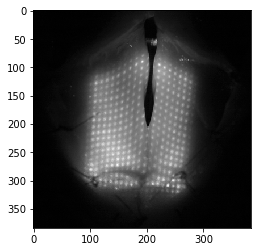

In [10]:
plt.imshow(X[0,:,:,0], cmap="gray")

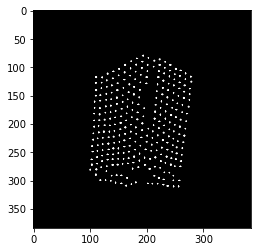

In [11]:
plt.imshow(y[0,:,:,0], cmap="gray")

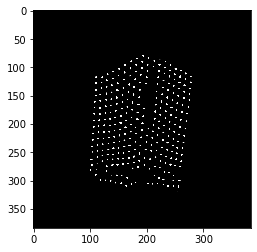

In [12]:
plt.imshow(y_pred[0,:,:,0], cmap="gray")

In [13]:
plt.imsave("y.png",y[0,:,:,0], cmap="gray")

In [14]:
plt.imsave("y_pred.png",y_pred[0,:,:,0], cmap="gray")